### Data exploration

In [38]:
# Importing libraries

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

In [39]:
# Reading our datasets(Training/Testing)

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

Survived
0    549
1    342
Name: count, dtype: int64
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


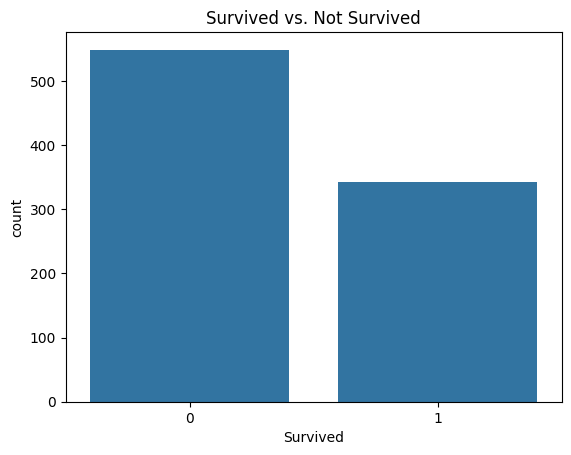

In [40]:
# Class imbalance
import seaborn as sns
print(train['Survived'].value_counts())
print(train['Survived'].value_counts(normalize=True))

# 1. Class imbalance (Survival counts)
sns.countplot(data=train, x='Survived')
plt.title('Survived vs. Not Survived')
plt.show()

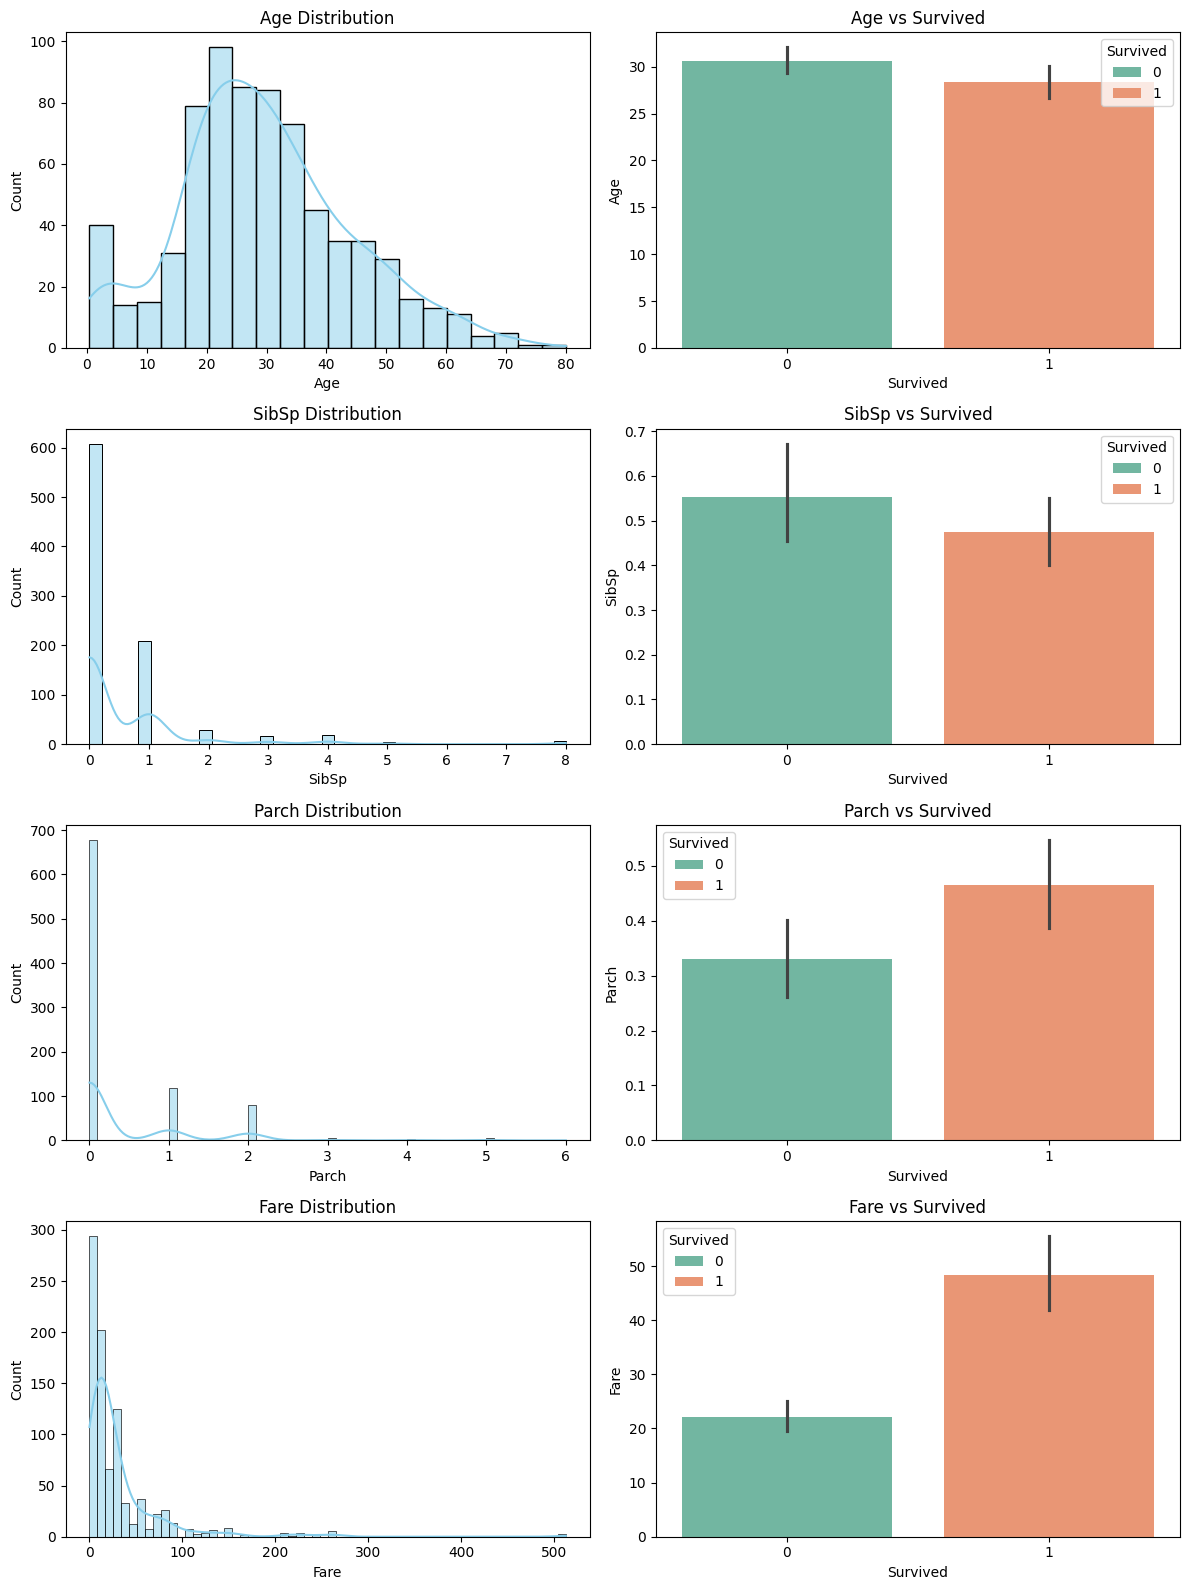

In [41]:
# Numerical Distributions
numerical_cols = ['Age', 'SibSp', 'Parch', 'Fare']
n_cols = 2
n_rows = len(numerical_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
plt.subplots_adjust(hspace=0.4)

for i, col in enumerate(numerical_cols):
    # Distribution plot
    sns.histplot(train[col], kde=True, ax=axes[i][0], color='skyblue')
    axes[i][0].set_title(f'{col} Distribution')

    # Barplot vs target
    sns.barplot(x='Survived', y=col, data=train, ax=axes[i][1], palette='Set2', hue='Survived')
    axes[i][1].set_title(f'{col} vs Survived')

plt.tight_layout()
plt.show()


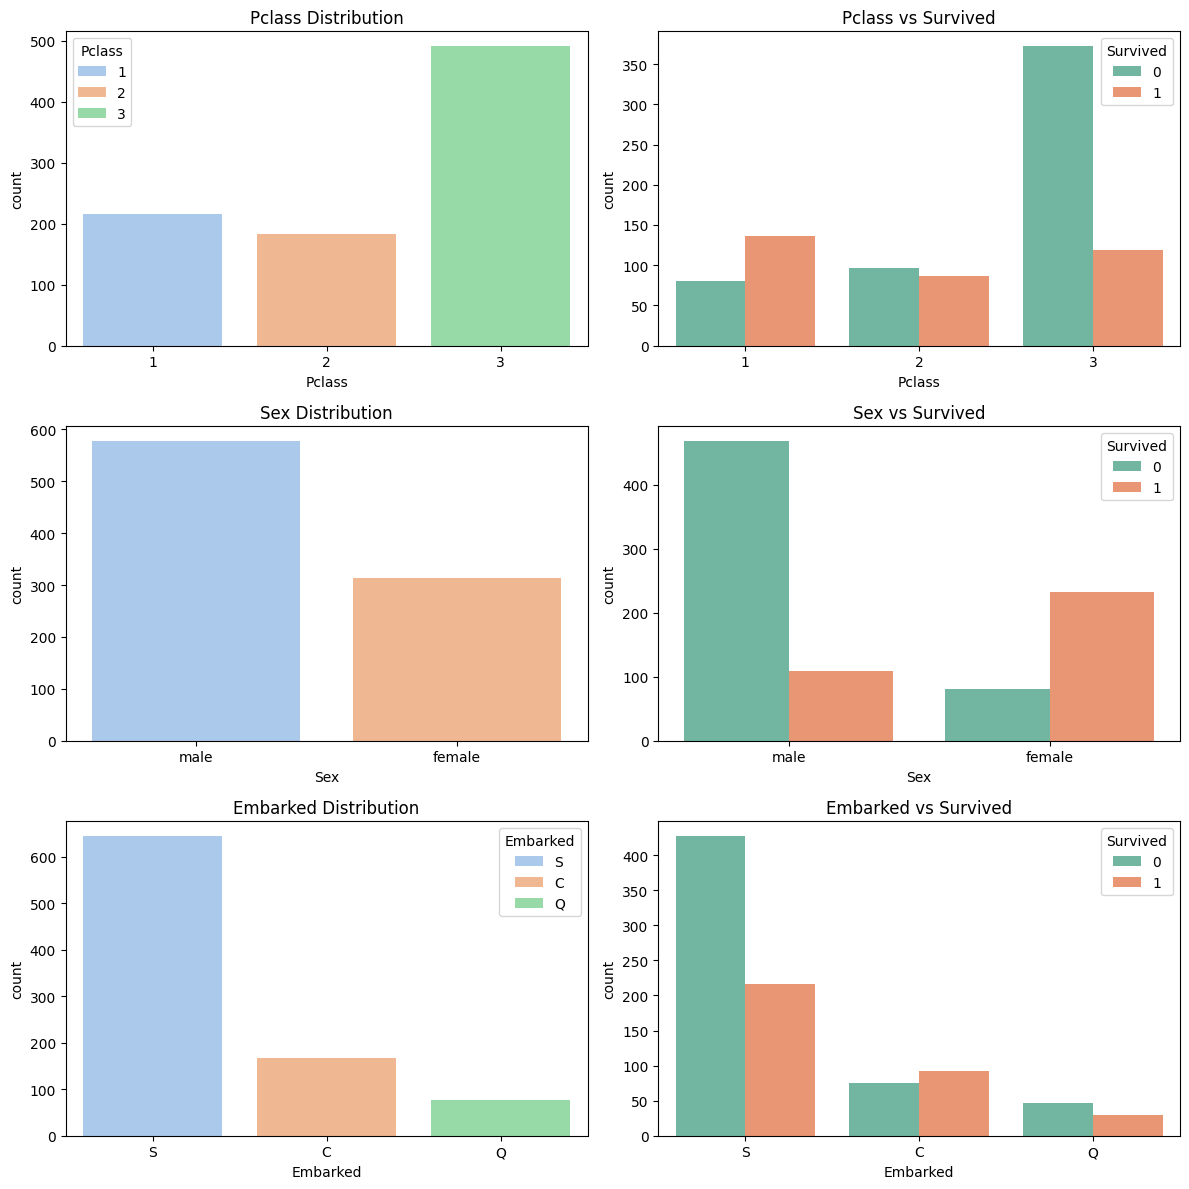

In [42]:
# Categorical Distributions
categorical_cols = ['Pclass', 'Sex', 'Embarked']
n_cols = 2
n_rows = len(categorical_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
plt.subplots_adjust(hspace=0.4)

for i, col in enumerate(categorical_cols):
    # Distribution plot for categorical feature
    sns.countplot(x=col, hue=col, data=train, ax=axes[i][0], palette='pastel')
    axes[i][0].set_title(f'{col} Distribution')

    # Countplot of feature grouped by target
    sns.countplot(x=col, hue='Survived', data=train, ax=axes[i][1], palette='Set2')
    axes[i][1].set_title(f'{col} vs Survived')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Survival Rate by Gender')

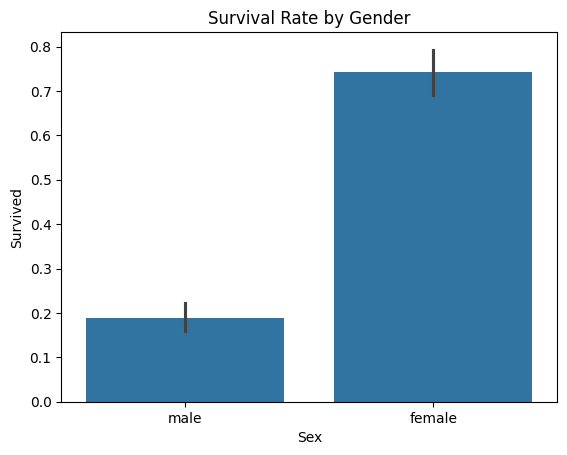

In [43]:
# Survival rate by sex
sns.barplot(data=train, x='Sex', y='Survived')
plt.title('Survival Rate by Gender')

Text(0.5, 1.0, 'Survival Rate by Passenger Class')

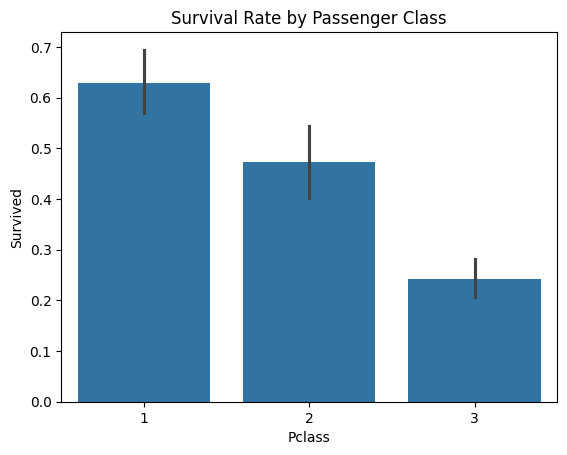

In [44]:
# Survival rate by passenger class
sns.barplot(data=train, x='Pclass', y='Survived')
plt.title('Survival Rate by Passenger Class')

Text(0.5, 1.0, 'Survival Rate by Age Group')

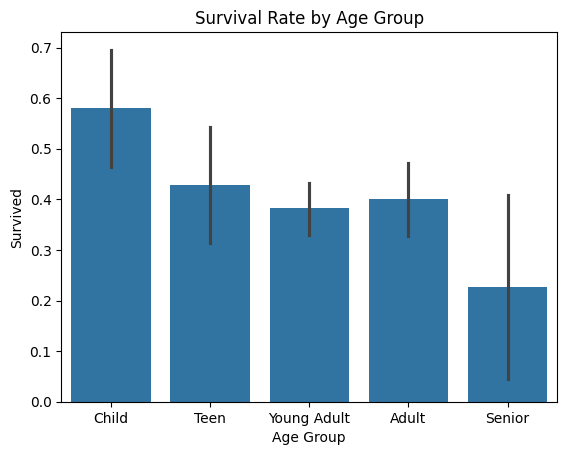

In [45]:
# Survival rate by age
train['Age Group'] = pd.cut(train['Age'], bins=[0, 12, 18, 35, 60, 80], labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])

sns.barplot(data=train, x='Age Group', y='Survived')
plt.title('Survival Rate by Age Group')

### Data Preprocessing

In [46]:
# Combined training & testing data sets to handle missing values later

combined = pd.concat([train, test], ignore_index=True)

In [47]:
# Missing value count per feature

test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [48]:
# Extracting titles (Characters after the comma & before the dot)

combined['Title'] = combined['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [50]:
# Define different categoric features
categorical_features = ['Sex', 'Embarked', 'Cabin', 'Pclass', 'Title']

# Categorical transfomer pipeline

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [51]:
# Numeric_features
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch']

# Numeric transfomer pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [52]:
# Preprocessing steps 

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ]
)

In [53]:
# Dropped the 'Age Group' column I added before to
# visualize the survival rate by age

combined.drop('Age Group', inplace=True, axis=1)

### Model Building

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [55]:
# Split the combined data set

train_data = combined.iloc[:891].copy()
test_data = combined.iloc[891:].copy()

In [56]:
X = train_data.drop(['Survived', 'Name', 'Ticket'], axis=1)
y = train_data['Survived']

In [57]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [58]:
# Used Pipeline since some columns have non numerical values
# which couldn't be converted when I tried to fit my models

classification_models = {
        'Logistic Regression' : Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(max_iter=1000))
        ]),
        'RandomForestClassifier' : Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier())
        ]),
        'XGBoost' : Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier())
        ])
    }

results = {}

In [59]:
np.random.seed(42) # To avoid randomness

for mode_name, model in classification_models.items():
    model.fit(X_train, y_train)
    results[mode_name] = model.score(X_test, y_test)
results

{'Logistic Regression': 0.8212290502793296,
 'RandomForestClassifier': 0.8044692737430168,
 'XGBoost': 0.8044692737430168}

<Axes: >

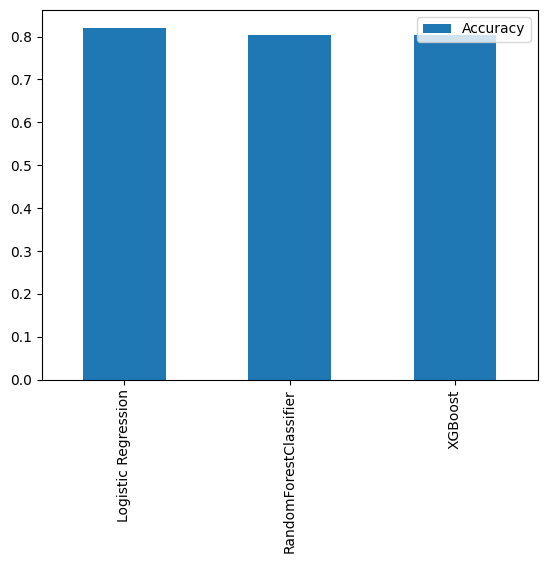

In [60]:
results_df = pd.DataFrame(results.values(),
                          results.keys(),
                          columns=['Accuracy'])
results_df.plot.bar()

# Notice that Logistic Regression scored the highest, with ~82% accuracy

### Logistic Regression Tuning

In [61]:
# Logistic Regression hyperparameters
from sklearn.model_selection import GridSearchCV
log_reg_grid = {"classifier__C": np.logspace(-4, 4, 20),
                "classifier__solver": ["liblinear"]}

In [62]:
# Hyperparameter Tuning using GridSearchCV

pipe = Pipeline([
    ('estimator', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

gs_log = GridSearchCV(estimator=pipe,
             param_grid=log_reg_grid)

gs_log.fit(X_train, y_train)

,estimator,Pipeline(step..._iter=1000))])
,param_grid,"{'classifier__C': array([1.0000...00000000e+04]), 'classifier__solver': ['liblinear']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


In [63]:
# Finding best parameters for tuning

gs_log.best_params_

{'classifier__C': np.float64(29.763514416313132),
 'classifier__solver': 'liblinear'}

In [64]:
gs_log.score(X_test, y_test)

0.7988826815642458

In [65]:
clf = LogisticRegression(solver='liblinear', C=29.763514416313132)

pipe = Pipeline([
    ('estimator', preprocessor),
    ('classifier', clf)
])

pipe.fit(X_train, y_train)

,steps,"[('estimator', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Model Evaluation


In [66]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
y_preds = pipe.predict(X_test)

In [67]:
confusion_matrix(y_test, y_preds)

array([[88, 17],
       [19, 55]])

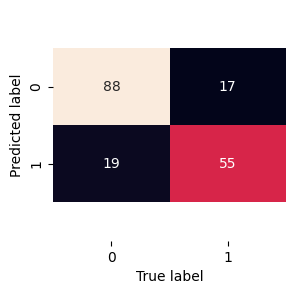

In [68]:
def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    
plot_conf_mat(y_test, y_preds)

In [69]:
accuracy_score(y_test, y_preds)

0.7988826815642458

In [70]:
precision_score(y_test, y_preds)

0.7638888888888888

In [71]:
recall_score(y_test, y_preds)

0.7432432432432432

In [72]:
# Cross-validated Accuracy
from sklearn.model_selection import cross_val_score
cross_val_acc = np.mean(cross_val_score(pipe,
                                        X,
                                        y,
                                        scoring="accuracy",
                                        cv=5))

cross_val_acc

np.float64(0.8226476680685456)

In [73]:
# Cross-validated Precision
cross_val_precision = np.mean(cross_val_score(pipe,
                                              X,
                                              y,
                                              scoring="precision",
                                              cv=5))

cross_val_precision

np.float64(0.771672995276792)

In [74]:
# Cross-validated Recall
cross_val_recall = np.mean(cross_val_score(pipe,
                                           X,
                                           y,
                                           scoring="recall",
                                           cv=5))

cross_val_recall

np.float64(0.7656862745098039)

### Final Predictions

After preprocessing the data (handling missing values, encoding categorical variables, and extracting titles from names), we trained and evaluated several classification models:      Logistic Regression, Random Forest Classifier, XGBoost Classifier.

All three models achieved similar accuracy:

'Logistic Regression': 0.8212,
'RandomForestClassifier': 0.8045,
'XGBoost': 0.8045

After hyperparameter tuning, Logistic Regression actually performed worse, dropping from 0.82 to 0.79.

### Insights

Feature engineering, especially extracting titles from names (like Mr., Mrs., Miss), had a positive impact on all models.

Tuning isn't always beneficial. In this case, tuning Logistic Regression may have led to overfitting or pushed it into a suboptimal configuration.